## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with the nuisance parameter bias

### Setup

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Methods

In [5]:
def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-12, 2e-11)

## Import

In [28]:
config = Dataset_load.load_config()



### Datasets

In [ ]:
livetimes = np.logspace(-2, 2,  13)[:6] 
livetimes = np.append(livetimes, np.logspace(0, 2, 7))
live = livetimes[7]



In [ ]:
dataset_asimov = Dataset_load.create_asimov(
   model = 'crab', source = "PKSflare",  parameters=None, livetime = f"{live}-hr",
)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz


In [ ]:
norm = 0.1
tilt = 0.025
bias = 0.0
resolution = 0.0

In [ ]:
setup = Setup(dataset_input=dataset_asimov)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.models.parameters['bias'].frozen = True

dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
dataset_asimov_N.irf_model.parameters['norm'].frozen = False
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

In [ ]:
a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

In [ ]:
%%time
fitting = 1
if fitting:
    fit = Fit(store_trace=False)
    result = fit.run([dataset_asimov])
    result_N = fit.run([dataset_asimov_N])

    dataset_asimov.models.write("data/1_model.yml", overwrite=1)
    dataset_asimov_N.models.write("data/1_model_N.yml", overwrite=1)


else:
    m = Models.read("data/1_model.yml")
    dataset_asimov.models = Models(
        [
            m[0],
            FoVBackgroundModel(
                dataset_name=dataset_asimov.name,
                spectral_model=m[1].spectral_model.copy(),
            ),
        ]
    )
    path = "data/1_model_N.yml"
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)

CPU times: user 138 ms, sys: 42.4 ms, total: 181 ms
Wall time: 183 ms


In [ ]:
dataset_asimov_N

In [18]:
print("index:")
print(
    dataset_asimov.models.parameters["index"].value,
    "pm",
    dataset_asimov.models.parameters["index"].error,
)
print(
    dataset_asimov_N.models.parameters["index"].value,
    "pm",
    dataset_asimov_N.models.parameters["index"].error,
)


print("lambda:")
print(1 / 60)
print(
    dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error,
)
print(
    dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error,
)

print("wihtout:",
    1 / dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error
    / dataset_asimov.models.parameters["lambda_"].value ** 2,
)
print("wiht",
    1 / dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error
    / dataset_asimov_N.models.parameters["lambda_"].value ** 2,
)

index:
2.390000104047178 pm 0.08167288044622172
2.3923146490228833 pm 0.08217085844683807
lambda:
0.016666666666666666
0.06993023613834477 pm 0.03285550840037323
0.07010638412406914 pm 0.03311727981624974
wihtout: 14.299966012150659 pm 6.718590975551487
wiht 14.264036185781217 pm 6.73813210559589


In [19]:
print(dataset_asimov.models)
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crab
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.390   +/-    0.08             
    amplitude                     :   3.76e-11   +/- 2.2e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.070   +/-    0.03 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : f9zaJ2TL-bkg
  Datasets names            : ['f9zaJ2TL']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.

In [20]:
# cutoff error in percent:
per = dataset_asimov.models.parameters["lambda_"].error/ dataset_asimov.models.parameters["lambda_"].value
print("without:",per)
per_N = dataset_asimov_N.models.parameters["lambda_"].error/ dataset_asimov_N.models.parameters["lambda_"].value
print("with:   ", per_N)

print("testL", np.sqrt(per**2 + 0.1 ** 2))

without: 0.4698326534372677
with:    0.4723860776736282
testL 0.4803568696666091


ValueError: [[0.12156862745098039, 0.47058823529411764, 0.7058823529411765], [0.6509803921568628, 0.807843137254902, 0.8901960784313725]] is not a valid value for color

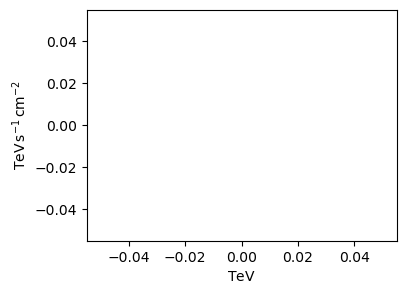

In [ ]:

energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)
axs.set_ylim(1e-12, 1e-10)

axs.set_xlim(0.3, 100)
fig.savefig("plots/asimov_crab.png")